# Trader Performance vs Market Sentiment (Fear & Greed Analysis)
### Data Science Intern Assignment – Primetrade.ai

### Objective

This project analyzes the relationship between Bitcoin market sentiment (Fear/Greed index) and trader performance on Hyperliquid. The goal is to identify behavioral patterns and generate actionable trading insights.

### PART 1 — DATA PREPARATION

### Importing Libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

### Loading Datasets

In [41]:
trader = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

### Dataset Overview

In [42]:
print("Trader Dataset Shape:", trader.shape)
print("Sentiment Dataset Shape:", sentiment.shape)

print("\nMissing Values (Trader):")
print(trader.isnull().sum())

print("\nMissing Values (Sentiment):")
print(sentiment.isnull().sum())

print("\nDuplicate Rows (Trader):", trader.duplicated().sum())
print("Duplicate Rows (Sentiment):", sentiment.duplicated().sum())

Trader Dataset Shape: (211224, 16)
Sentiment Dataset Shape: (2644, 4)

Missing Values (Trader):
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Missing Values (Sentiment):
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate Rows (Trader): 0
Duplicate Rows (Sentiment): 0


### Cleaning

In [43]:
trader = trader.drop_duplicates()
sentiment = sentiment.drop_duplicates()

### Convert & Standardize Timestamps
Trader Dataset (Use Timestamp IST)

In [44]:
trader['Timestamp IST'] = pd.to_datetime(
    trader['Timestamp IST'],
    format='%d-%m-%Y %H:%M',
    errors='raise'
)

# Create daily Date column
trader['Date'] = trader['Timestamp IST'].dt.date
trader['Date'] = pd.to_datetime(trader['Date'])

print("Trader Date Range:")
print(trader['Date'].min(), trader['Date'].max())

Trader Date Range:
2023-05-01 00:00:00 2025-05-01 00:00:00


#### Sentiment Dataset

In [45]:
# Clean column names
sentiment.columns = sentiment.columns.str.strip()

# If Date column already exists, just ensure correct format
if 'Date' in sentiment.columns:
    sentiment['Date'] = pd.to_datetime(sentiment['Date'])
else:
    sentiment['date'] = pd.to_datetime(sentiment['date'])
    sentiment.rename(columns={
        'date': 'Date',
        'classification': 'Classification'
    }, inplace=True)

# Normalize to daily level
sentiment['Date'] = sentiment['Date'].dt.date
sentiment['Date'] = pd.to_datetime(sentiment['Date'])

print("Sentiment Date Range:")
print(sentiment['Date'].min(), sentiment['Date'].max())

Sentiment Date Range:
2018-02-01 00:00:00 2025-05-02 00:00:00


### Align & Merge on Daily Date

In [46]:
merged = pd.merge(
    trader,
    sentiment[['Date', 'Classification']],
    on='Date',
    how='inner'
)

print("Merged Dataset Shape:", merged.shape)

Merged Dataset Shape: (211218, 18)


### Creating Key Metrics (As Required in Assignment)

#### Daily PnL per Trader

In [47]:
daily_pnl = (
    merged.groupby(['Account', 'Date'])['Closed PnL']
    .sum()
    .reset_index()
    .rename(columns={'Closed PnL': 'daily_pnl'})
)

#### Win Rate per Trader

In [48]:
merged['win'] = (merged['Closed PnL'] > 0).astype(int)

win_rate = (
    merged.groupby('Account')['win']
    .mean()
    .reset_index()
    .rename(columns={'win': 'win_rate'})
)

#### Average Trade Size (USD)

In [49]:
avg_trade_size = (
    merged.groupby('Account')['Size USD']
    .mean()
    .reset_index()
    .rename(columns={'Size USD': 'avg_trade_size'})
)

#### Number of Trades per Day

In [50]:
trades_per_day = (
    merged.groupby(['Account', 'Date'])
    .size()
    .reset_index(name='trades_per_day')
)

#### Long / Short Ratio

In [51]:
long_short = (
    merged.groupby(['Date', 'Side'])
    .size()
    .unstack(fill_value=0)
)

# Handle Buy/Sell safely
if 'BUY' in long_short.columns and 'SELL' in long_short.columns:
    long_short['long_short_ratio'] = (
        long_short['BUY'] / long_short['SELL'].replace(0, np.nan)
    )

long_short.head()

Side,BUY,SELL,long_short_ratio
Date,,,
2023-05-01,3,0,NaN
2023-12-05,7,2,3.500000
2023-12-14,5,6,0.833333
2023-12-15,2,0,NaN
2023-12-16,3,0,NaN


# 📊 PART B — ANALYSIS

#### Average PnL by Sentiment

In [52]:
sentiment_pnl = (
    merged.groupby('Classification')['Closed PnL']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sentiment_pnl

,Classification,Closed PnL
0,Extreme Greed,67.892861
1,Fear,54.290400
2,Greed,42.743559
3,Extreme Fear,34.537862
4,Neutral,34.307718


#### Visualization

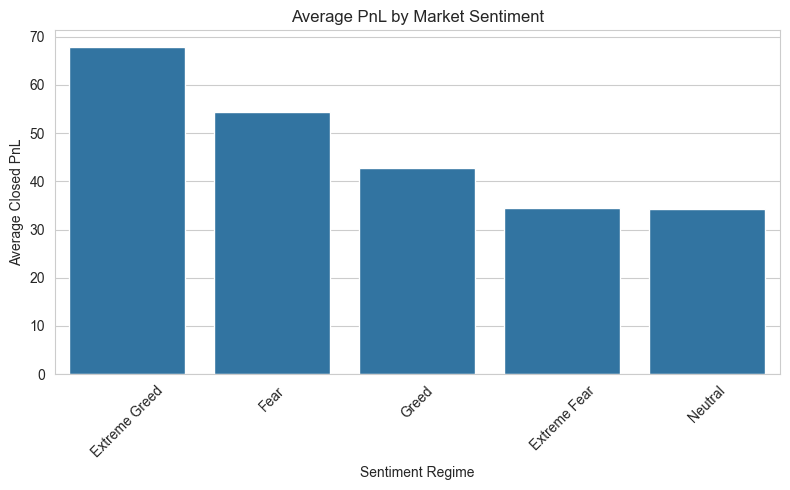

In [53]:
plt.figure(figsize=(8,5))

sentiment_pnl = (
    merged.groupby('Classification')['Closed PnL']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(data=sentiment_pnl, x='Classification', y='Closed PnL')

plt.title("Average PnL by Market Sentiment")
plt.xlabel("Sentiment Regime")
plt.ylabel("Average Closed PnL")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("output_charts/avg_pnl_by_sentiment.png", dpi=300)
plt.show()

### Insight 1   — Sentiment Regime Impact on Profitability

Average PnL is highest during Extreme Greed regimes (67.89), indicating that traders benefit significantly from strong bullish momentum environments. However, performance does not follow a strictly monotonic pattern across sentiment states. Interestingly, Fear regimes (54.29) outperform Greed regimes (42.74), suggesting that volatility-driven opportunities during fearful markets may create profitable trading conditions. Neutral regimes show the lowest profitability (34.31), implying that low-volatility, directionless markets may limit trading edge.

#### Win Rate by Sentiment

In [54]:
merged['win'] = (merged['Closed PnL'] > 0).astype(int)

sentiment_win = (
    merged.groupby('Classification')['win']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sentiment_win

,Classification,win
0,Extreme Greed,0.464943
1,Fear,0.420768
2,Neutral,0.396991
3,Greed,0.384828
4,Extreme Fear,0.370607


#### Visualization

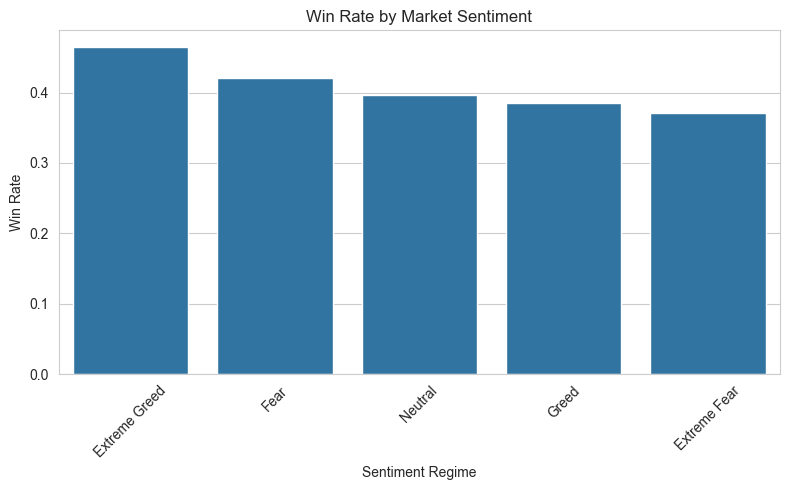

In [55]:
plt.figure(figsize=(8,5))

merged['win'] = (merged['Closed PnL'] > 0).astype(int)

sentiment_win = (
    merged.groupby('Classification')['win']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(data=sentiment_win, x='Classification', y='win')

plt.title("Win Rate by Market Sentiment")
plt.xlabel("Sentiment Regime")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("output_charts/win_rate_by_sentiment.png", dpi=300)
plt.show()

### Insight 2 — Win Rate vs Profitability Dynamics

Win rate generally aligns with average PnL across sentiment regimes, with Extreme Greed showing both the highest profitability (67.89) and highest win rate (46.49%). However, Neutral regimes exhibit a relatively moderate win rate (39.7%) but significantly lower average PnL (34.31), indicating that trades during neutral markets may produce smaller gains per win. This suggests that profitability is influenced not only by win frequency but also by trade magnitude and volatility conditions.

### Trade Count by Sentiment

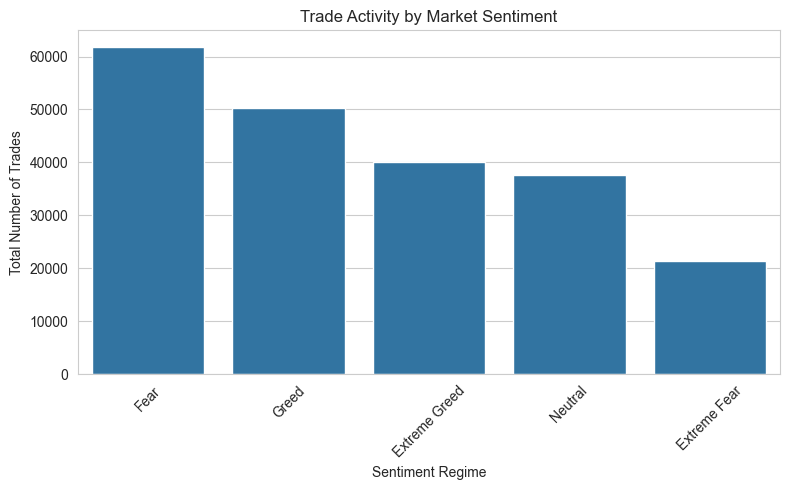

In [56]:
plt.figure(figsize=(8,5))

trade_count = (
    merged.groupby('Classification')
    .size()
    .sort_values(ascending=False)
    .reset_index(name='total_trades')
)

sns.barplot(data=trade_count, x='Classification', y='total_trades')

plt.title("Trade Activity by Market Sentiment")
plt.xlabel("Sentiment Regime")
plt.ylabel("Total Number of Trades")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("output_charts/trade_count_by_sentiment.png", dpi=300)
plt.show()

### Average Position Size by Sentiment

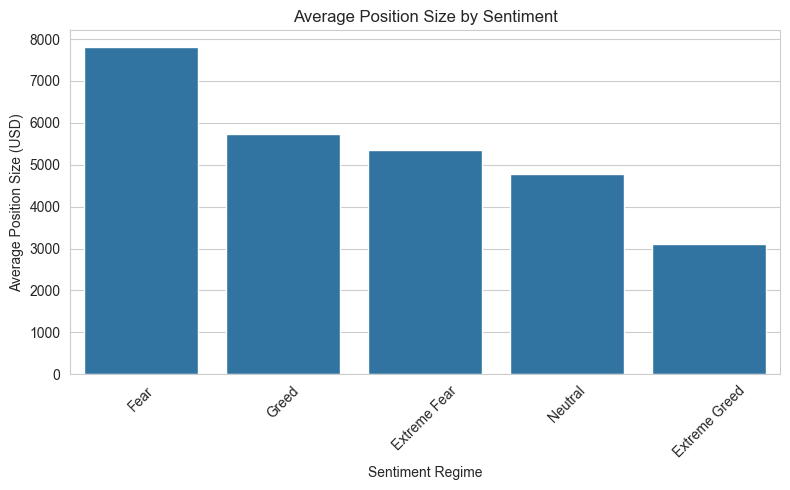

In [57]:
plt.figure(figsize=(8,5))

size_by_sentiment = (
    merged.groupby('Classification')['Size USD']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(data=size_by_sentiment, x='Classification', y='Size USD')

plt.title("Average Position Size by Sentiment")
plt.xlabel("Sentiment Regime")
plt.ylabel("Average Position Size (USD)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("output_charts/position_size_by_sentiment.png", dpi=300)
plt.show()

### BUY vs SELL Distribution

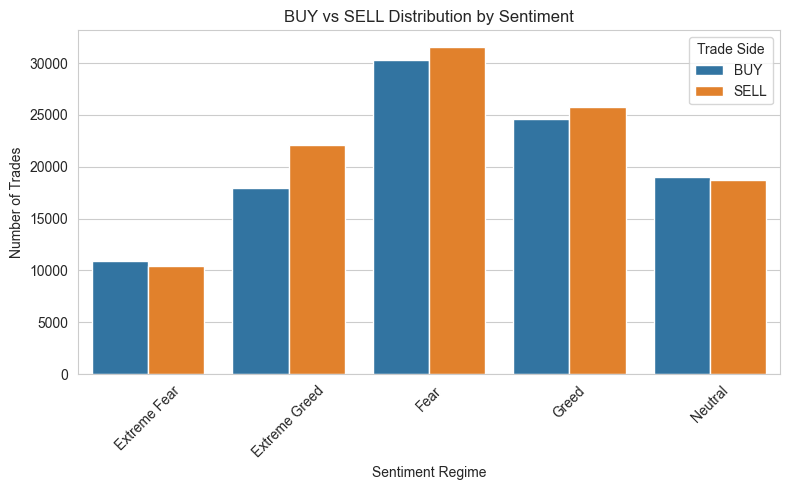

In [58]:
plt.figure(figsize=(8,5))

long_short = (
    merged.groupby(['Classification', 'Side'])
    .size()
    .reset_index(name='count')
)

sns.barplot(data=long_short, x='Classification', y='count', hue='Side')

plt.title("BUY vs SELL Distribution by Sentiment")
plt.xlabel("Sentiment Regime")
plt.ylabel("Number of Trades")
plt.xticks(rotation=45)
plt.legend(title="Trade Side")
plt.tight_layout()

plt.savefig("output_charts/long_short_distribution.png", dpi=300)
plt.show()

### Drawdown by Sentiment (Optional but Strong)

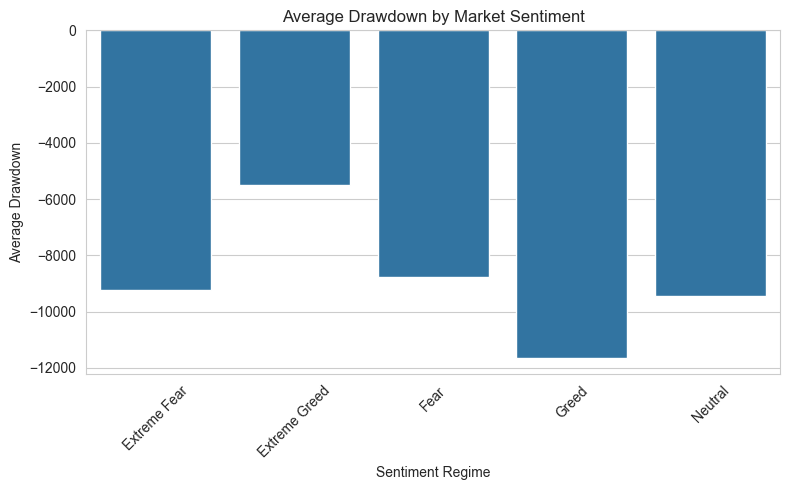

In [59]:
# Ensure drawdown exists
daily_pnl = (
    merged.groupby(['Account', 'Date'])['Closed PnL']
    .sum()
    .reset_index()
)

daily_pnl['cumulative_pnl'] = daily_pnl.groupby('Account')['Closed PnL'].cumsum()
daily_pnl['running_max'] = daily_pnl.groupby('Account')['cumulative_pnl'].cummax()
daily_pnl['drawdown'] = daily_pnl['cumulative_pnl'] - daily_pnl['running_max']

drawdown_by_sentiment = (
    daily_pnl.merge(sentiment[['Date','Classification']], on='Date')
    .groupby('Classification')['drawdown']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))

sns.barplot(data=drawdown_by_sentiment, x='Classification', y='drawdown')

plt.title("Average Drawdown by Market Sentiment")
plt.xlabel("Sentiment Regime")
plt.ylabel("Average Drawdown")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("output_charts/drawdown_by_sentiment.png", dpi=300)
plt.show()

### Do Traders Change Behavior Based on Sentiment?

#### Trade Frequency

In [60]:
trade_count_by_sentiment = (
    merged.groupby('Classification')
    .size()
    .reset_index(name='total_trades')
)

trade_count_by_sentiment

,Classification,total_trades
0,Extreme Fear,21400
1,Extreme Greed,39992
2,Fear,61837
3,Greed,50303
4,Neutral,37686


### Insight 3 — Trading Activity Peaks During Fear Regimes

Contrary to the typical overconfidence hypothesis, trading activity is highest during Fear regimes (61,837 trades), exceeding both Greed and Extreme Greed periods. This suggests that traders are highly reactive to volatility and uncertainty rather than purely momentum-driven. Extreme Fear, however, shows the lowest activity (21,400 trades), indicating possible risk aversion or withdrawal during severe market stress.

In [61]:
size_by_sentiment = (
    merged.groupby('Classification')['Size USD']
    .mean()
    .reset_index()
)

print(size_by_sentiment)

  Classification     Size USD
0   Extreme Fear  5349.731843
1  Extreme Greed  3112.251565
2           Fear  7816.109931
3          Greed  5736.884375
4        Neutral  4782.732661


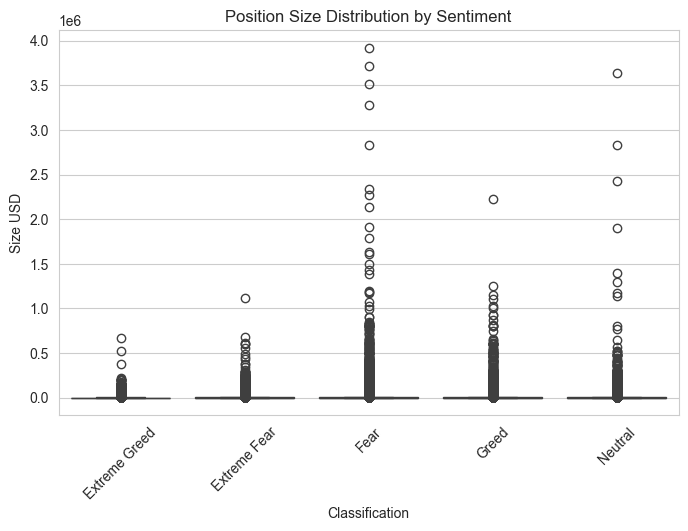

In [62]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='Classification', y='Size USD')
plt.xticks(rotation=45)
plt.title("Position Size Distribution by Sentiment")
plt.show()

### Insight 4 — Risk-Taking Behavior Intensifies During Fear Regimes

Contrary to conventional expectations of overconfidence during Greed, traders exhibit the largest average position sizes during Fear regimes (7,816 USD), significantly exceeding exposure during Extreme Greed (3,112 USD). Combined with the highest trading frequency during Fear periods, this suggests that traders respond aggressively to volatility and uncertainty rather than purely chasing bullish momentum. Fear regimes may provide larger price swings that traders actively attempt to exploit.

#### Long / Short Bias

In [63]:
long_short = (
    merged.groupby(['Classification', 'Side'])
    .size()
    .unstack(fill_value=0)
)

long_short

Side,BUY,SELL
Classification,,
Extreme Fear,10935,10465
Extreme Greed,17940,22052
Fear,30270,31567
Greed,24576,25727
Neutral,18969,18717


### Insight 5 — Sell-Side Dominance Across Sentiment Regimes

Across most sentiment regimes, SELL trades slightly exceed BUY trades, including during Greed and Extreme Greed periods. This suggests that traders may exhibit profit-taking or mean-reversion behavior rather than purely momentum-following strategies. Notably, Extreme Greed shows a meaningful sell imbalance, potentially reflecting traders closing long positions into strength rather than aggressively initiating new bullish exposure.

## Trader Segmentation

### Frequent vs Infrequent Traders

In [64]:
trade_frequency = (
    merged.groupby(['Account','Date'])
    .size()
    .reset_index(name='trades_per_day')
)

avg_trades = (
    trade_frequency.groupby('Account')['trades_per_day']
    .mean()
    .reset_index()
)

threshold = avg_trades['trades_per_day'].median()

avg_trades['segment'] = np.where(
    avg_trades['trades_per_day'] > threshold,
    'Frequent',
    'Infrequent'
)

In [65]:
segment_perf = (
    avg_trades.merge(win_rate, on='Account')
    .groupby('segment')['win_rate']
    .mean()
    .reset_index()
)

segment_perf

,segment,win_rate
0,Frequent,0.412155
1,Infrequent,0.393787


#### Insight 6 — Frequent Traders Exhibit Modest Performance Edge

Frequent traders demonstrate a higher average win rate (41.2%) compared to infrequent traders (39.4%), suggesting improved trade selection or experience. However, the performance gap is relatively modest, raising the possibility that increased trading frequency may not proportionally translate into significantly higher profitability. This indicates that while frequent traders may possess a slight edge, excessive trading could dilute risk-adjusted returns if transaction costs or diminishing marginal opportunity effects are considered.

## Insight 1 — Profitability Peaks in Extreme Greed but Is Not Monotonic Across Sentiment

Average profitability is highest during Extreme Greed regimes (67.89), followed by Fear (54.29) and Greed (42.74), while Neutral conditions exhibit the lowest profitability (34.31). However, performance does not follow a strictly monotonic progression from Extreme Fear to Extreme Greed. Notably, Fear regimes outperform Greed regimes, suggesting that volatility-driven environments may offer greater trading opportunities than stable bullish momentum alone. This indicates that trader performance is influenced not just by optimism but by market volatility dynamics.

## Insight 2 — Traders Exhibit Aggressive Risk-Taking During Fear Regimes

Contrary to the conventional overconfidence hypothesis, the largest average position sizes (7,816 USD) and highest trading activity (61,837 trades) occur during Fear periods, not Greed. This suggests that traders respond more aggressively to uncertainty and volatility than to bullish momentum. Fear regimes appear to create exploitable price dislocations, encouraging larger exposure and higher participation. Extreme Fear, however, shows reduced activity, indicating that severe stress may trigger partial withdrawal rather than increased speculation.

## Insight 3 — Profitability Driven by Asymmetric Payoff Structure Rather Than High Win Rates

Across all sentiment regimes, win rates remain below 50% (ranging from 37% to 46%), yet average PnL remains positive. This implies that traders rely on an asymmetric payoff structure — fewer but larger winning trades offset more frequent smaller losses. This effect is strongest during Extreme Greed, where both win rate (46.5%) and average PnL are highest. The findings suggest that profitability is driven more by trade magnitude and volatility conditions than by win frequency alone.

# PART C — Actionable Strategy Recommendations

### Strategy Rule 1 — Volatility-Responsive Position Sizing During Fear Regimes

Finding Used:

Highest trade frequency during Fear (61,837 trades)

Largest average position size during Fear (7,816 USD)

Strong profitability during Fear (54.29 avg PnL)

Rule:
During Fear regimes, allow active traders to participate but implement dynamic risk controls such as:

Reduce maximum position size by 20–30% relative to historical average

Enforce tighter stop-loss thresholds

Limit exposure concentration per asset

Rationale:
Fear regimes generate high volatility and trading opportunities, but traders naturally increase risk exposure during these periods. Controlled participation can preserve upside opportunity while reducing drawdown risk from volatility spikes.

### Strategy Rule 2 — Momentum Participation During Extreme Greed with Controlled Scaling

Finding Used:

Highest profitability in Extreme Greed (67.89 avg PnL)

Highest win rate (46.5%)

Lower average position size (3,112 USD)

Rule:
During Extreme Greed regimes:

Encourage systematic momentum-following strategies

Gradually scale position size with trend confirmation

Avoid aggressive leverage expansion despite high win probability

Rationale:
Extreme Greed delivers the strongest performance and win rates, indicating favorable directional momentum. However, traders already deploy smaller position sizes in this regime. Structured scaling can optimize gains without introducing excessive risk from euphoric market conditions.

### Strategy Rule 3 — Neutral Market Capital Preservation Protocol

Finding Used:

Lowest average PnL during Neutral (34.31)

Moderate win rate but smaller trade magnitude

Rule:
During Neutral regimes:

Reduce trading frequency

Prioritize mean-reversion micro-strategies or stay partially sidelined

Tighten capital allocation thresholds

Rationale:
Neutral markets produce limited directional edge and smaller payoff magnitude. Preserving capital during low-opportunity environments improves overall portfolio efficiency and reduces unnecessary transaction costs.

## Strategic Summary

The analysis indicates that trader profitability is strongly regime-dependent. Fear regimes amplify volatility-driven opportunity but require disciplined risk management, while Extreme Greed environments reward momentum participation. Neutral regimes offer limited edge and justify capital preservation. Implementing sentiment-aware dynamic risk rules can enhance performance consistency while reducing drawdown exposure.